# Object detection model

> Object Detection Model


- skip_showdoc: true
- skip_exec: true

## COCO

### Data download

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

#
# Only the required images will be downloaded (if necessary).
# By default, only detections are loaded
#

In [ ]:
dataset = foz.load_zoo_dataset(
    name="coco-2017",
    dataset_dir= "Data/coco",
    splits=["validation","train"],
    classes=["person", "car"],
    max_samples=50,
)

Found annotations at 'Data/coco/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Found annotations at 'Data/coco/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-validation-train-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
# Visualize the dataset in the FiftyOne App
session = fo.launch_app(dataset)

In [ ]:
classses = dataset.default_classes

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Create a histogram plot
output_notebook()

Loading BokehJS ...

### Dataset and DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import VisionDataset, CocoDetection

import torch.utils.data
from torch.utils.data import DataLoader

In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
train_path = './Data/coco/train'
val_path = './Data/coco/validation'

# Define transforms
# Define transforms for the dataset
transform2 = v2.Compose(
    [
        v2.ToImage(),
        # v2.Resize(size = desired_size),  # Resize image
        # v2.RandomPhotometricDistort(p=0.2),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.4),
        # # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [ ]:
# Load KITTI train dataset
train_dataset = CocoDetection(root=f'{train_path}/data',
                              annFile=f'{train_path}/labels.json', 
                              transform = transform2)

# Load KITTI test dataset
test_dataset =CocoDetection(root=f'{val_path}/data',
                            annFile=f'{val_path}/labels.json',
                            transform=transform2)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
sample = train_dataset[49]
img, target = sample
print(f"{type(img) = }\n{type(target) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'list'>


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset)

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset)

In [ ]:
len(train_dataset2), len(test_dataset2)

(50, 50)

In [ ]:
batch_size = 2

train_loader = DataLoader(train_dataset2,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)),
                          num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)

In [ ]:
sample = train_dataset2[10]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['image_id', 'boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    if 'scores' in label:
        for bbox, item, score in zip(label['boxes'], label['labels'], label['scores']):
            if score > 0.2:
                cv2.rectangle(image_cv2,
                              (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                              (0, 255, 0), 2)
            
                # Display the label
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image_cv2, str(item),
                            (int(bbox[0]), int(bbox[1]) - 10),
                            font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        for bbox, item in zip(label['boxes'], label['labels']):
            # Draw the bounding box
            cv2.rectangle(image_cv2,
                          (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                          (0, 255, 0), 2)
        
            # Display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_cv2, classses[item],
                        (int(bbox[0]), int(bbox[1]) - 10),
                        font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb

def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(math.sqrt(len(images)))
    ncols = int(np.floor(len(images)/nrows))
        
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the image using Matplotlib
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = np.asarray(image).transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        
        # Display image
        ax.imshow(image_rgb)
        ax.axis('off')

    for ax in axes.flat[len(images):]:
        ax.axis('off')
    plt.show()

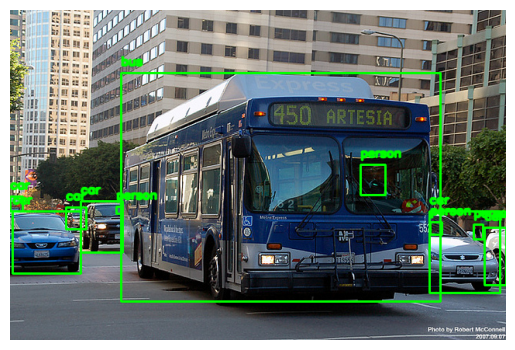

In [ ]:
show_image(train_dataset2[18])

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


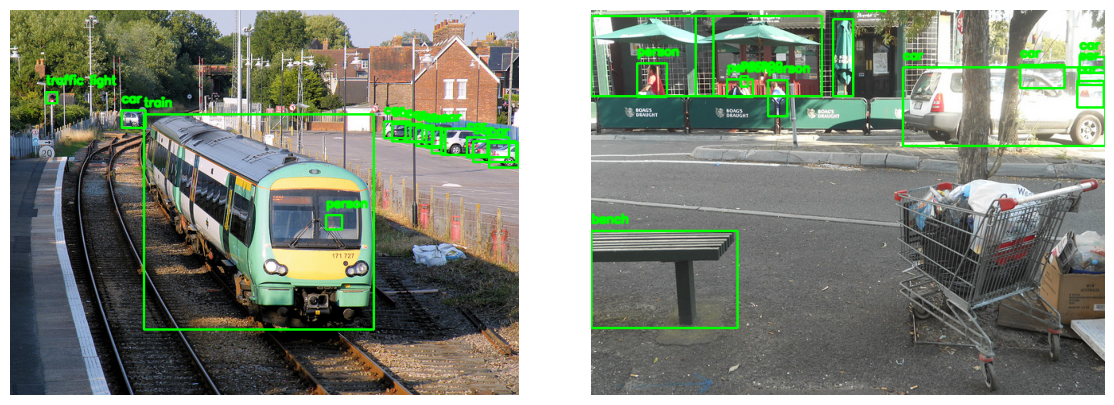

In [ ]:
show_images(images, labels, figsize=(15, 5))